# Токсичные комментарии на русском: RNN, LSTM и GRU

   1. Выберите на сайте huggingface.co датасет для обучения модели предсказания тональности (можно взять https://huggingface.co/datasets/sepidmnorozy/Russian_sentiment или любой другой)
   2. Загрузите обучающий и тестовый датасеты
   3. Обучите модели RNN, LSTM и GRU на тренинговом датасете для предсказания тональности фраз 
   4. Для тестового датасета сделайте предсказания тональности
   5. Выведите метрики качества обученных моделей для тестовой выборки

## 1. Установка и базовые настройки

In [ ]:
import os, sys, re, json, math, random, time
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("device:", device)

# Кэш
CACHE_DIR = Path("./cache_toxic_ru")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Для более быстрого скачивания с HF (при наличии тулинга)
os.environ.setdefault("HF_HUB_ENABLE_HF_TRANSFER", "1")

# Цвет Иннополиса
corp_col = '#40ba21'

def create_gradient_cmap(hex_color):
    rgb_color = tuple(int(hex_color[i:i+2], 16)/255 for i in (1, 3, 5))
    return LinearSegmentedColormap.from_list("", [(1, 1, 1), rgb_color])

c_map = create_gradient_cmap(corp_col)

f:\Staff\Иннополис\Innopolis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda


## 2. Загрузка датасетов (train/test)

In [ ]:
DATASET_REPO = "AlexSham/Toxic_Russian_Comments"
HF_TEST_URI  = f"hf://datasets/{DATASET_REPO}/test.jsonl"
safe_read_jsonl_via_pandas(HF_TEST_URI)

,text,label
0,хорошо пошло!,0
1,"посмотрела, как будто дома побывала. как река ...",0
2,"отдам котят 1,5 месяца в добрые руки.",0
3,"0,5литровая баночка 200р стоит в таганроге. та...",0
4,речь шла о радужных зонтиках над верандой.,0
...,...,...
24824,и ты будь здоров,0
24825,не дорога а прям стекло но правда битое (h),0
24826,спасибо большое. буду ждать хороших новостей. ...,0
24827,активирую установку 🌈🌈🌈👍😎🔥🔥🔥,0


In [ ]:
import pandas as pd

DATASET_REPO = "AlexSham/Toxic_Russian_Comments"
HF_TRAIN_URI = f"hf://datasets/{DATASET_REPO}/train.jsonl"
HF_TEST_URI  = f"hf://datasets/{DATASET_REPO}/test.jsonl"

# Прямо читаем jsonl с Hugging Face. Никаких кэшей, никаких try/except.
df_train_raw = pd.read_json(HF_TRAIN_URI, lines=True)
df_test_raw  = pd.read_json(HF_TEST_URI,  lines=True)

print("train shape:", df_train_raw.shape, "test shape:", df_test_raw.shape)
display(df_train_raw.head(3))

train shape: (223461, 2) test shape: (24829, 2)


,text,label
0,"видимо в разных регионах называют по разному ,...",0
1,"понятно что это нарушение правил, писать капсл...",1
2,"какие классные, жизненные стихи....",0


## 3. Приведение колонок: текст и бинарная метка

In [11]:
import pandas as pd

def build_clean_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw[['text', 'label']].copy()

    df['text'] = df['text'].astype(str)

    df['label'] = pd.to_numeric(df['label'], errors='coerce')

    df = df[df['label'].isin([0, 1])]

    df['label'] = df['label'].astype('int64')

    df = df.dropna(subset=['text']) \
           .drop_duplicates(subset=['text']) \
           .reset_index(drop=True)

    return df

train_df = build_clean_df(df_train_raw)
test_df  = build_clean_df(df_test_raw)

print(train_df["label"].value_counts(dropna=False))
display(train_df.head(3))

label
0    183314
1     40142
Name: count, dtype: int64


,text,label
0,"видимо в разных регионах называют по разному ,...",0
1,"понятно что это нарушение правил, писать капсл...",1
2,"какие классные, жизненные стихи....",0


# Токенизация и построение словаря

In [13]:
import re
import numpy as np
import pandas as pd
from collections import Counter

SEED = 42
MAX_LEN = 120        # длина последовательности
VOCAB_SIZE = 40000   # максимум токенов в словаре
MIN_FREQ = 2         # минимальная частота токена, чтобы попасть в словарь
VAL_FRAC = 0.1       # доля валидации из train

# Токенизация
TOKEN_RE = re.compile(r"[A-Za-zА-Яа-яЁё0-9]+", re.UNICODE)

def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())

# Словарь по train
def build_vocab(texts):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    # частотный срез и ограничение размера
    items = [w for w, c in counter.items() if c >= MIN_FREQ]
    items = sorted(items, key=lambda w: counter[w], reverse=True)[:VOCAB_SIZE - 2]
    # 0: <PAD>, 1: <UNK>
    vocab = {
        "<PAD>": 0, # Пустой токен
        "<UNK>": 1 # Токен "неизвестное слово"
        }
    for i, w in enumerate(items, start=2):
        vocab[w] = i
    return vocab

# Преобразование текста в индексы фиксированной длины
# Каждое слово заменяем индексом из словаря, неизвестные слова получают <UNK>. Длину урезаем до MAX_LEN, недостающее <PAD>
def text_to_ids(text: str, vocab: dict, max_len: int = MAX_LEN):
    ids = [vocab.get(tok, 1) for tok in tokenize(text)]  # 1 = <UNK>
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids = ids + [0] * (max_len - len(ids))           # 0 = <PAD>
    return np.array(ids, dtype=np.int64)

# Разбивка на train/val и векторизация
def vectorize_split(train_df: pd.DataFrame, test_df: pd.DataFrame):
    # строим словарь
    vocab = build_vocab(train_df["text"].tolist())

    # перемешиваем и делим на train/val
    train_df = train_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    n_val = int(len(train_df) * VAL_FRAC)
    val_df = train_df.iloc[:n_val]
    tr_df  = train_df.iloc[n_val:]

    # векторизация
    X_train = np.stack([text_to_ids(t, vocab) for t in tr_df["text"]], axis=0)
    y_train = tr_df["label"].astype(int).to_numpy()

    X_val   = np.stack([text_to_ids(t, vocab) for t in val_df["text"]], axis=0)
    y_val   = val_df["label"].astype(int).to_numpy()

    X_test  = np.stack([text_to_ids(t, vocab) for t in test_df["text"]], axis=0)
    y_test  = test_df["label"].astype(int).to_numpy()

    return vocab, X_train, y_train, X_val, y_val, X_test, y_test

vocab, X_train, y_train, X_val, y_val, X_test, y_test = vectorize_split(train_df, test_df)

print("len(vocab):", len(vocab))
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


len(vocab): 40000
X_train: (201111, 120) X_val: (22345, 120) X_test: (24829, 120)


# DataLoader-ы

In [14]:
BATCH_SIZE = int(os.getenv("BATCH_SIZE", 256))

def make_loader(X, y, batch_size, shuffle):
    tens_x = torch.tensor(X, dtype=torch.long)
    tens_y = torch.tensor(y, dtype=torch.long)
    ds = TensorDataset(tens_x, tens_y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

trainloader = make_loader(X_train, y_train, BATCH_SIZE, shuffle=True)
valloader   = make_loader(X_val,   y_val,   BATCH_SIZE, shuffle=False)
testloader  = make_loader(X_test,  y_test,  BATCH_SIZE, shuffle=False)

len(trainloader), len(valloader), len(testloader)

(786, 88, 97)

# Модели: RNN, LSTM и GRU

In [16]:
# Простые константы, без окружения
EMB_DIM     = 128
HIDDEN_DIM  = 128
NUM_LAYERS  = 1
DROPOUT     = 0.2
NUM_CLASSES = 2

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, dropout, num_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, nonlinearity="tanh")
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.emb(x)                           # [B, T, E]
        out, h_n = self.rnn(x)                    # h_n: [num_layers, B, H]
        h_last = h_n[-1]                          # [B, H]
        h_last = self.drop(h_last)
        logits = self.fc(h_last)                  # [B, C]
        return logits

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, dropout, num_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.emb(x)
        out, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]
        h_last = self.drop(h_last)
        logits = self.fc(h_last)
        return logits

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, dropout, num_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.gru = nn.GRU(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.emb(x)
        out, h_n = self.gru(x)
        h_last = h_n[-1]
        h_last = self.drop(h_last)
        logits = self.fc(h_last)
        return logits

# Инициализация
rnn_model  = RNNClassifier(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT, NUM_CLASSES).to(device)
lstm_model = LSTMClassifier(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT, NUM_CLASSES).to(device)
gru_model  = GRUClassifier(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT, NUM_CLASSES).to(device)

models_dict = {
    "RNN": rnn_model,
    "LSTM": lstm_model,
    "GRU": gru_model,
}

sum_params = lambda m: sum(p.numel() for p in m.parameters())
{k: sum_params(v) for k, v in models_dict.items()}

{'RNN': 5153282, 'LSTM': 5252354, 'GRU': 5219330}

## 7. Обучение с кэшем весов

In [24]:
EPOCHS      = 15
LR          = 2e-3

def train_one_model(model, name, trainloader, valloader):
    model_path = CACHE_DIR / f"{name.lower()}_best.pt"
    
    if False:
        print(f"[{name}] найден кэш весов: {model_path}. Загружаю и пропускаю обучение.")
        model.load_state_dict(torch.load(model_path, map_location=device))
        return model

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = -1.0
    for epoch in range(1, EPOCHS+1):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        for X, y in tqdm(trainloader, desc=f"[{name}] epoch {epoch}/{EPOCHS}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * y.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total   += y.size(0)

        train_acc = correct / total
        # валидация
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X, y in valloader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                pred = logits.argmax(dim=1)
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_prec = precision_score(all_labels, all_preds, average='binary', zero_division=0)
        val_rec  = recall_score(all_labels, all_preds, average='binary', zero_division=0)
        val_f1   = f1_score(all_labels, all_preds, average='binary', zero_division=0)
        print(f"[{name}] epoch {epoch}: train_acc={train_acc:.4f} | val_f1={val_f1:.4f} (p={val_prec:.4f}, r={val_rec:.4f})")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), model_path)
            print(f"[{name}] сохранены новые лучшие веса -> {model_path}")
    return model

for name, m in models_dict.items():
    _ = train_one_model(m, name, trainloader, valloader)

print("Готово.")

[RNN] epoch 1/15: 100%|██████████| 786/786 [00:08<00:00, 89.65it/s] 


[RNN] epoch 1: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)
[RNN] сохранены новые лучшие веса -> cache_toxic_ru\rnn_best.pt


[RNN] epoch 2/15: 100%|██████████| 786/786 [00:09<00:00, 80.30it/s]


[RNN] epoch 2: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 3/15: 100%|██████████| 786/786 [00:08<00:00, 88.09it/s] 


[RNN] epoch 3: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 4/15: 100%|██████████| 786/786 [00:09<00:00, 84.41it/s] 


[RNN] epoch 4: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 5/15: 100%|██████████| 786/786 [00:09<00:00, 80.43it/s] 


[RNN] epoch 5: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 6/15: 100%|██████████| 786/786 [00:08<00:00, 87.65it/s]


[RNN] epoch 6: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 7/15: 100%|██████████| 786/786 [00:08<00:00, 92.40it/s] 


[RNN] epoch 7: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 8/15: 100%|██████████| 786/786 [00:08<00:00, 94.52it/s] 


[RNN] epoch 8: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 9/15: 100%|██████████| 786/786 [00:08<00:00, 94.42it/s] 


[RNN] epoch 9: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 10/15: 100%|██████████| 786/786 [00:08<00:00, 94.51it/s] 


[RNN] epoch 10: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 11/15: 100%|██████████| 786/786 [00:08<00:00, 93.39it/s] 


[RNN] epoch 11: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 12/15: 100%|██████████| 786/786 [00:08<00:00, 90.35it/s] 


[RNN] epoch 12: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 13/15: 100%|██████████| 786/786 [00:10<00:00, 77.16it/s] 


[RNN] epoch 13: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 14/15: 100%|██████████| 786/786 [00:07<00:00, 101.35it/s]


[RNN] epoch 14: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[RNN] epoch 15/15: 100%|██████████| 786/786 [00:07<00:00, 104.48it/s]


[RNN] epoch 15: train_acc=0.8204 | val_f1=0.0000 (p=0.0000, r=0.0000)


[LSTM] epoch 1/15: 100%|██████████| 786/786 [00:15<00:00, 49.83it/s]


[LSTM] epoch 1: train_acc=0.8943 | val_f1=0.8031 (p=0.8320, r=0.7761)
[LSTM] сохранены новые лучшие веса -> cache_toxic_ru\lstm_best.pt


[LSTM] epoch 2/15: 100%|██████████| 786/786 [00:15<00:00, 49.94it/s]


[LSTM] epoch 2: train_acc=0.9502 | val_f1=0.8685 (p=0.9248, r=0.8186)
[LSTM] сохранены новые лучшие веса -> cache_toxic_ru\lstm_best.pt


[LSTM] epoch 3/15: 100%|██████████| 786/786 [00:16<00:00, 48.73it/s]


[LSTM] epoch 3: train_acc=0.9694 | val_f1=0.8794 (p=0.9053, r=0.8549)
[LSTM] сохранены новые лучшие веса -> cache_toxic_ru\lstm_best.pt


[LSTM] epoch 4/15: 100%|██████████| 786/786 [00:15<00:00, 49.40it/s]


[LSTM] epoch 4: train_acc=0.9751 | val_f1=0.8811 (p=0.9161, r=0.8487)
[LSTM] сохранены новые лучшие веса -> cache_toxic_ru\lstm_best.pt


[LSTM] epoch 5/15: 100%|██████████| 786/786 [00:15<00:00, 50.17it/s]


[LSTM] epoch 5: train_acc=0.9781 | val_f1=0.8818 (p=0.9081, r=0.8569)
[LSTM] сохранены новые лучшие веса -> cache_toxic_ru\lstm_best.pt


[LSTM] epoch 6/15: 100%|██████████| 786/786 [00:15<00:00, 49.52it/s]


[LSTM] epoch 6: train_acc=0.9857 | val_f1=0.8816 (p=0.8992, r=0.8646)


[LSTM] epoch 7/15: 100%|██████████| 786/786 [00:15<00:00, 49.73it/s]


[LSTM] epoch 7: train_acc=0.9882 | val_f1=0.8785 (p=0.8852, r=0.8718)


[LSTM] epoch 8/15: 100%|██████████| 786/786 [00:15<00:00, 50.37it/s]


[LSTM] epoch 8: train_acc=0.9900 | val_f1=0.8842 (p=0.8933, r=0.8753)
[LSTM] сохранены новые лучшие веса -> cache_toxic_ru\lstm_best.pt


[LSTM] epoch 9/15: 100%|██████████| 786/786 [00:16<00:00, 48.80it/s]


[LSTM] epoch 9: train_acc=0.9915 | val_f1=0.8750 (p=0.8691, r=0.8810)


[LSTM] epoch 10/15: 100%|██████████| 786/786 [00:15<00:00, 49.53it/s]


[LSTM] epoch 10: train_acc=0.9926 | val_f1=0.8740 (p=0.8717, r=0.8763)


[LSTM] epoch 11/15: 100%|██████████| 786/786 [00:15<00:00, 49.75it/s]


[LSTM] epoch 11: train_acc=0.9925 | val_f1=0.8795 (p=0.8942, r=0.8653)


[LSTM] epoch 12/15: 100%|██████████| 786/786 [00:15<00:00, 50.09it/s]


[LSTM] epoch 12: train_acc=0.9930 | val_f1=0.8822 (p=0.8966, r=0.8683)


[LSTM] epoch 13/15: 100%|██████████| 786/786 [00:15<00:00, 49.85it/s]


[LSTM] epoch 13: train_acc=0.9935 | val_f1=0.8799 (p=0.8970, r=0.8634)


[LSTM] epoch 14/15: 100%|██████████| 786/786 [00:15<00:00, 49.55it/s]


[LSTM] epoch 14: train_acc=0.9946 | val_f1=0.8755 (p=0.8792, r=0.8718)


[LSTM] epoch 15/15: 100%|██████████| 786/786 [00:15<00:00, 49.66it/s]


[LSTM] epoch 15: train_acc=0.9959 | val_f1=0.8782 (p=0.8933, r=0.8636)


[GRU] epoch 1/15: 100%|██████████| 786/786 [00:12<00:00, 63.87it/s]


[GRU] epoch 1: train_acc=0.9920 | val_f1=0.8884 (p=0.9183, r=0.8604)
[GRU] сохранены новые лучшие веса -> cache_toxic_ru\gru_best.pt


[GRU] epoch 2/15: 100%|██████████| 786/786 [00:12<00:00, 62.42it/s]


[GRU] epoch 2: train_acc=0.9945 | val_f1=0.8819 (p=0.9012, r=0.8634)


[GRU] epoch 3/15: 100%|██████████| 786/786 [00:12<00:00, 63.02it/s]


[GRU] epoch 3: train_acc=0.9952 | val_f1=0.8777 (p=0.8817, r=0.8738)


[GRU] epoch 4/15: 100%|██████████| 786/786 [00:12<00:00, 64.55it/s]


[GRU] epoch 4: train_acc=0.9954 | val_f1=0.8829 (p=0.9018, r=0.8648)


[GRU] epoch 5/15: 100%|██████████| 786/786 [00:12<00:00, 63.18it/s]


[GRU] epoch 5: train_acc=0.9960 | val_f1=0.8851 (p=0.8976, r=0.8730)


[GRU] epoch 6/15: 100%|██████████| 786/786 [00:12<00:00, 64.23it/s]


[GRU] epoch 6: train_acc=0.9964 | val_f1=0.8782 (p=0.8804, r=0.8760)


[GRU] epoch 7/15: 100%|██████████| 786/786 [00:12<00:00, 64.23it/s]


[GRU] epoch 7: train_acc=0.9964 | val_f1=0.8804 (p=0.9096, r=0.8529)


[GRU] epoch 8/15: 100%|██████████| 786/786 [00:12<00:00, 64.17it/s]


[GRU] epoch 8: train_acc=0.9964 | val_f1=0.8786 (p=0.8807, r=0.8765)


[GRU] epoch 9/15: 100%|██████████| 786/786 [00:12<00:00, 63.00it/s]


[GRU] epoch 9: train_acc=0.9970 | val_f1=0.8807 (p=0.9023, r=0.8601)


[GRU] epoch 10/15: 100%|██████████| 786/786 [00:12<00:00, 64.35it/s]


[GRU] epoch 10: train_acc=0.9970 | val_f1=0.8786 (p=0.8772, r=0.8800)


[GRU] epoch 11/15: 100%|██████████| 786/786 [00:12<00:00, 63.41it/s]


[GRU] epoch 11: train_acc=0.9961 | val_f1=0.8774 (p=0.8951, r=0.8604)


[GRU] epoch 12/15: 100%|██████████| 786/786 [00:12<00:00, 62.94it/s]


[GRU] epoch 12: train_acc=0.9969 | val_f1=0.8753 (p=0.8822, r=0.8686)


[GRU] epoch 13/15: 100%|██████████| 786/786 [00:12<00:00, 63.74it/s]


[GRU] epoch 13: train_acc=0.9973 | val_f1=0.8758 (p=0.8737, r=0.8780)


[GRU] epoch 14/15: 100%|██████████| 786/786 [00:12<00:00, 63.69it/s]


[GRU] epoch 14: train_acc=0.9968 | val_f1=0.8799 (p=0.8998, r=0.8609)


[GRU] epoch 15/15: 100%|██████████| 786/786 [00:12<00:00, 63.60it/s]


[GRU] epoch 15: train_acc=0.9972 | val_f1=0.8810 (p=0.9145, r=0.8499)
Готово.


# Оценка на тестовой выборке и визуализация


Результаты на тестовой выборке:
Модель		Точность	Precision	Recall		F1-Score
-----------------------------------------------------------------
RNN             82.04%		0.0000		0.0000		0.0000


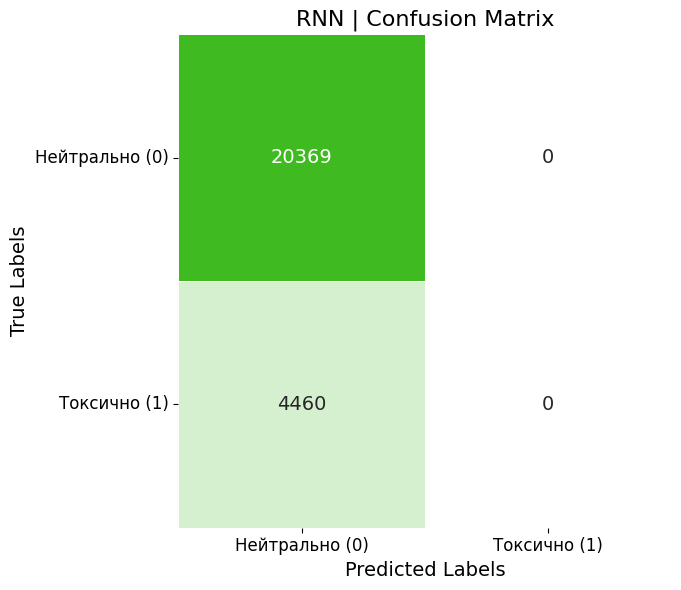


Результаты на тестовой выборке:
Модель		Точность	Precision	Recall		F1-Score
-----------------------------------------------------------------
LSTM            95.68%		0.8938		0.8621		0.8777


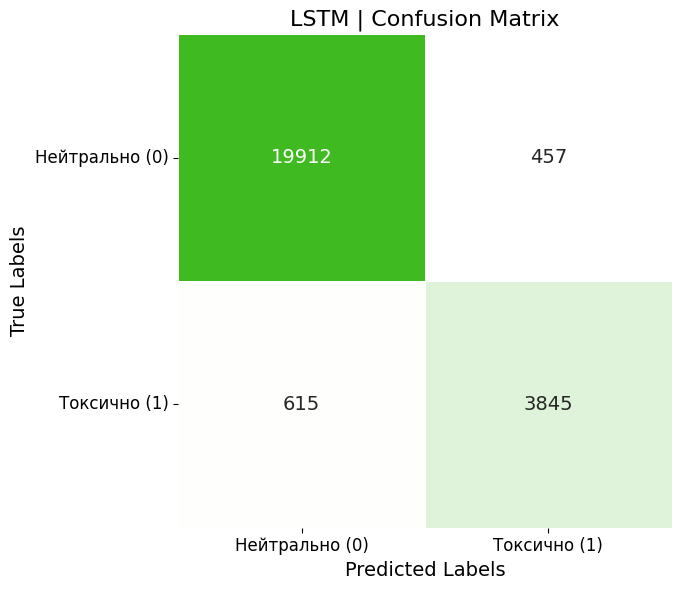


Результаты на тестовой выборке:
Модель		Точность	Precision	Recall		F1-Score
-----------------------------------------------------------------
GRU             96.04%		0.9139		0.8610		0.8866


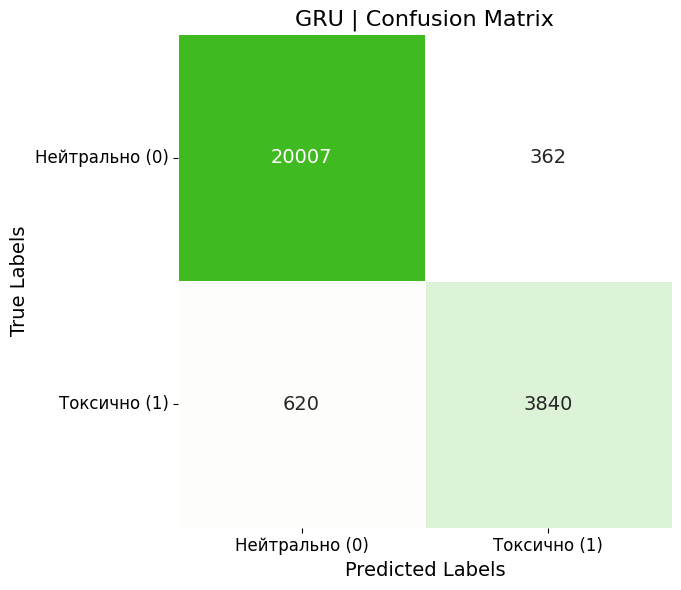

In [25]:
def evaluate_model(model, test_loader):

    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total

    # Расчет precision, recall, f1-score
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall    = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1        = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    cm        = confusion_matrix(all_labels, all_preds, labels=[0,1])

    return accuracy, precision, recall, f1, cm, np.array(all_labels), np.array(all_preds)



fig_paths = {}
for key, model in models_dict.items():
    acc, prec, rec, f1, cm, y_true, y_pred = evaluate_model(model, testloader)
    
    print("\nРезультаты на тестовой выборке:")
    print("Модель\t\tТочность\tPrecision\tRecall\t\tF1-Score")
    print("-" * 65)
    
    print(f"{key:<15} {acc:.2f}%\t\t{prec:.4f}\t\t{rec:.4f}\t\t{f1:.4f}")
        
    # Матрица ошибок
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap=c_map, 
        linewidths=.5, 
        square=True,
        cbar=False,
        annot_kws={"size": 14}
    )
    plt.title(f'{key} | Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks([0.5, 1.5], ['Нейтрально (0)', 'Токсично (1)'], fontsize=12)
    plt.yticks([0.5, 1.5], ['Нейтрально (0)', 'Токсично (1)'], fontsize=12, rotation=0)
    out_path = CACHE_DIR / f"cm_{key.lower()}.png"
    
    plt.tight_layout()
    plt.show()


## RNN-модель не справилась с задачей! LSTM и GRU показали очень близкие результаты с точностью порядка 95%!